In [12]:
# =================================================================================
# SECTION 1: PROJECT SCAFFOLDING & CONFIGURATION
# =================================================================================

# ---------------------------------------------------------------------------------
# 1.1: IMPORTS
# All necessary libraries for the project.
# ---------------------------------------------------------------------------------
%matplotlib inline 
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel, ViTConfig
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold # We might use this later for robustness
from collections import defaultdict
import copy

# Set a seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [13]:

# ---------------------------------------------------------------------------------
# 1.2: CONFIGURATION CLASS
# This class holds all hyperparameters and settings in one place.
# ---------------------------------------------------------------------------------
class Config:
    # --- Data Paths and Domains ---
    # In your Config class
    DATA_DIR = r"D:\Salaar Masood\pacs-dataset\pacs_data"
    DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
    
    # --- Model & Architecture ---
    # In your Config class
    MODEL_NAME = "WinKawaks/vit-tiny-patch16-224"
    NUM_CLASSES = 7
    NUM_HEADS = 4
    DROPOUT_OPTIONS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
    # DROPOUT_OPTIONS = [0.1, 0.2, 0.3, 0.4, 0.5]

    
    # --- Training Hyperparameters ---
    BATCH_SIZE = 128
    NUM_EPOCHS = 5
    LEARNING_RATE = 1e-4  # A good starting point for fine-tuning transformers
    OPTIMIZER = "AdamW"   # AdamW is generally preferred for transformers
    
    # --- Hardware & Reproducibility ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 42

# Instantiate the config
config = Config()

# Print out the configuration to verify
print("--- Project Configuration ---")
for key, value in config.__class__.__dict__.items():
    if not key.startswith('__'):
        print(f"{key}: {value}")
print("---------------------------")
print(f"Device: {config.DEVICE}")

# ---------------------------------------------------------------------------------
# 1.3: RESULTS TRACKER
# A list to store the final results from each LODO experiment run.
# This will be converted to a DataFrame at the end for analysis.
# ---------------------------------------------------------------------------------
experiment_results = []

print("\nProject scaffolding is complete. Ready for Section 2: Data Loading.")

--- Project Configuration ---
DATA_DIR: D:\Salaar Masood\pacs-dataset\pacs_data
DOMAINS: ['art_painting', 'cartoon', 'photo', 'sketch']
MODEL_NAME: WinKawaks/vit-tiny-patch16-224
NUM_CLASSES: 7
NUM_HEADS: 4
DROPOUT_OPTIONS: [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
BATCH_SIZE: 128
NUM_EPOCHS: 5
LEARNING_RATE: 0.0001
OPTIMIZER: AdamW
DEVICE: cuda
SEED: 42
---------------------------
Device: cuda

Project scaffolding is complete. Ready for Section 2: Data Loading.


In [14]:
# =================================================================================
# SECTION 2: DATA LOADING & PREPROCESSING
# =================================================================================

# ---------------------------------------------------------------------------------
# 2.1: IMAGE TRANSFORMATIONS
# Define the transformations for training (with augmentation) and validation/testing.
# ---------------------------------------------------------------------------------

# The ViT model was pre-trained on images of size 224x224
IMG_SIZE = 224

# The normalization values are standard for many pre-trained models
# but it's good practice to use the ones specified by the model's authors if available.
# For ViT, a simple (0.5, 0.5, 0.5) normalization is common.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(), # A simple data augmentation technique
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}


In [15]:
# ---------------------------------------------------------------------------------
# 2.2: CUSTOM PACS DATASET CLASS
# This class will read the images and labels from our specific folder structure.
# ---------------------------------------------------------------------------------
class PACSDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        """
        Args:
            root_dir (string): Directory with all the domain folders.
            domains (list of string): List of domains to include in this dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.domains = domains
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Discover all classes (dog, elephant, etc.) and map them to integers
        self.classes = sorted(os.listdir(os.path.join(root_dir, domains[0])))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Load image paths and labels from the specified domains
        for domain in self.domains:
            domain_path = os.path.join(self.root_dir, domain)
            for class_name in self.classes:
                class_path = os.path.join(domain_path, class_name)
                for img_name in os.listdir(class_path):
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [16]:
# =================================================================================
# SECTION 2.3: DATALOADER HELPER FUNCTION (NEW 80/20 SPLIT VERSION)
# =================================================================================
# Replace the old get_dataloaders function in Section 2 of BOTH notebooks with this.

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def get_dataloaders(root_dir, target_domain, all_domains, batch_size, seed):
    """
    Creates dataloaders for a LODO split using an 80/20 split on the source domains.
    """
    source_domains = [d for d in all_domains if d != target_domain]
    
    print(f"--- Creating DataLoaders (80/20 Split Strategy) ---")
    print(f"Target (Test) Domain: {target_domain}")
    print(f"Source Domains for Train/Val: {source_domains}")
    
    # 1. Create a single, large dataset by combining all source domains
    source_dataset = PACSDataset(
        root_dir=root_dir, 
        domains=source_domains, 
        transform=data_transforms['train'] # Use training transforms for the whole source
    )
    
    # We need to perform a stratified split to ensure the train and val sets
    # have a similar distribution of classes.
    indices = list(range(len(source_dataset)))
    labels = source_dataset.labels
    
    # Use sklearn's train_test_split to get indices for an 80% train / 20% val split
    train_idx, val_idx = train_test_split(
        indices, 
        test_size=0.2, 
        stratify=labels, 
        random_state=seed
    )
    
    # 2. Create the training and validation subsets
    train_subset = Subset(source_dataset, train_idx)
    val_subset = Subset(source_dataset, val_idx)
    
    # Important: The validation subset should not use training augmentations (like RandomFlip).
    # We create a new dataset object for validation with the correct transforms.
    # This is a cleaner way to handle transforms for subsets.
    val_dataset_clean = PACSDataset(root_dir=root_dir, domains=source_domains, transform=data_transforms['val'])
    val_subset_final = Subset(val_dataset_clean, val_idx)
    
    # 3. Create the test dataset from the full target domain
    test_dataset = PACSDataset(
        root_dir=root_dir, 
        domains=[target_domain], 
        transform=data_transforms['val']
    )

    # 4. Create the DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset_final, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f"Source data size: {len(source_dataset)}")
    print(f"  -> Training on: {len(train_subset)} images (80%)")
    print(f"  -> Validating on: {len(val_subset_final)} images (20%)")
    print(f"Testing on full '{target_domain}' domain: {len(test_dataset)} images")
    print("----------------------------------------------------")
    
    return train_loader, val_loader, test_loader

In [17]:
# =================================================================================
# SECTION 3: THE MODEL ARCHITECTURE (SHARED HEAD STRATEGY - with updated logging)
# =================================================================================

class SharedHeadViT(nn.Module):
    def __init__(self, model_name, num_classes, dropout_rates: list):
        super(SharedHeadViT, self).__init__()
        self.vit_backbone = ViTModel.from_pretrained(model_name)
        hidden_dim = self.vit_backbone.config.hidden_size
        self.dropout_layers = nn.ModuleList([nn.Dropout(p=rate) for rate in dropout_rates])
        self.shared_head = nn.Linear(hidden_dim, num_classes)

    def update_dropout_rates(self, new_rates: list):
        assert len(new_rates) == len(self.dropout_layers), "Number of new rates must match number of dropout layers."
        for i, dropout_layer in enumerate(self.dropout_layers):
            dropout_layer.p = new_rates[i]
            
    def forward(self, images):
        z = self.vit_backbone(pixel_values=images).last_hidden_state[:, 0, :]
        
        path_outputs = {} # Changed from head_outputs
        for i, dropout_layer in enumerate(self.dropout_layers):
            z_dropped = dropout_layer(z)
            logits = self.shared_head(z_dropped)
            
            ### LOGGING CHANGE ###
            # The dictionary key is now 'path_x' for clarity
            path_outputs[f'path_{i+1}'] = logits 
            
        return path_outputs

print("SharedHeadViT class defined with updated logging.")

SharedHeadViT class defined with updated logging.


In [18]:
# =================================================================================
# SECTION 4: TRAINING & EVALUATION LOGIC
# =================================================================================
# =================================================================================
# SECTION 4.1: TRAIN_ONE_EPOCH FUNCTION (FINAL CORRECTED VERSION)
# =================================================================================

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_winner_loss = 0.0
    path_correct_preds = defaultdict(int)
    total_samples = 0
    progress_bar = tqdm(train_loader, desc="Training Epoch", leave=False)

    for images, labels in progress_bar:
        ### THE FIX IS HERE ###
        # Move each tensor to the device on its own line.
        images = images.to(device)
        labels = labels.to(device)
        
        z = model.vit_backbone(pixel_values=images).last_hidden_state[:, 0, :]
        z_detached = z.detach()

        path_outputs = {}
        all_losses = {}
        batch_accuracies = {}

        for i, dropout_layer in enumerate(model.dropout_layers):
            path_name = f'path_{i+1}'
            
            live_logits = model.shared_head(dropout_layer(z))
            detached_logits = model.shared_head(dropout_layer(z_detached))

            path_outputs[path_name] = live_logits
            
            all_losses[path_name] = {
                'live': criterion(live_logits, labels),
                'detached': criterion(detached_logits, labels)
            }

            _, preds = torch.max(live_logits, 1)
            correct = torch.sum(preds == labels).item()
            batch_accuracies[path_name] = correct / labels.size(0)

        winner_path_name = max(batch_accuracies, key=batch_accuracies.get)

        final_loss = all_losses[winner_path_name]['live']
        for path_name, loss_dict in all_losses.items():
            if path_name != winner_path_name:
                final_loss += loss_dict['detached']
        
        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()

        total_winner_loss += all_losses[winner_path_name]['live'].item()
        for path_name, logits in path_outputs.items():
             _, preds = torch.max(logits, 1)
             path_correct_preds[path_name] += torch.sum(preds == labels).item()
        total_samples += labels.size(0)
    
    final_path_accuracies = {name: (correct / total_samples) for name, correct in path_correct_preds.items()}
    return {
        "avg_winner_loss": total_winner_loss / len(train_loader),
        "path_accuracies": final_path_accuracies
    }

In [19]:
# ---------------------------------------------------------------------------------
# 4.2: EVALUATE FUNCTION
# (This function is correct and does not need to change)
# ---------------------------------------------------------------------------------
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0
    total_samples = 0
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            total_samples += labels.size(0)
            head_outputs = model(images)
            all_logits = torch.stack(list(head_outputs.values()))
            ensembled_logits = torch.mean(all_logits, dim=0)
            loss = criterion(ensembled_logits, labels)
            total_loss += loss.item()
            _, preds = torch.max(ensembled_logits, 1)
            correct_preds += torch.sum(preds == labels).item()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_preds / total_samples
    return {
        "avg_loss": avg_loss,
        "accuracy": accuracy
    }

In [20]:
# =================================================================================
# SECTION 5: THE MAIN EXPERIMENT LOOP (SHARED HEAD - FINAL CORRECTED VERSION)
# =================================================================================
config = Config()
lodo_histories = {} # <--- ADD THIS LINE

for target_domain in config.DOMAINS:
    print(f"==============================================================")
    print(f"  STARTING LODO EXPERIMENT: Target Domain = {target_domain.upper()}")
    print(f"==============================================================")
    
    train_loader, val_loader, test_loader = get_dataloaders(
        root_dir=config.DATA_DIR,
        target_domain=target_domain,
        all_domains=config.DOMAINS,
        batch_size=config.BATCH_SIZE, seed=config.SEED
    )
    
    current_dropout_rates = list(np.random.choice(
        config.DROPOUT_OPTIONS, 
        config.NUM_HEADS, 
        replace=False
    ))
    
    model = SharedHeadViT(
        model_name=config.MODEL_NAME,
        num_classes=config.NUM_CLASSES,
        dropout_rates=current_dropout_rates
    ).to(config.DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    best_val_accuracy = 0.0
    best_model_state = None

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_accuracy": []
    }
    
    for epoch in range(config.NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{config.NUM_EPOCHS} ---")
        print(f"Current Dropout Rates: { {f'path_{i+1}': rate for i, rate in enumerate(current_dropout_rates)} }")
        
        train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, config.DEVICE)
        val_metrics = evaluate(model, val_loader, criterion, config.DEVICE)

        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Avg Winner Loss: {train_metrics['avg_winner_loss']:.4f}")
        print(f"  Validation Loss: {val_metrics['avg_loss']:.4f}")
        print(f"  Validation Accuracy: {val_metrics['accuracy']:.4f}")

        history["train_loss"].append(train_metrics['avg_winner_loss'])
        history["val_loss"].append(val_metrics['avg_loss'])
        history["val_accuracy"].append(val_metrics['accuracy'])
        
        if val_metrics['accuracy'] > best_val_accuracy:
            print(f"  New best validation accuracy! Saving model state.")
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = copy.deepcopy(model.state_dict())

        ### FIX 1 ###
        # Use the correct key: 'path_accuracies'
        epoch_winner_path_name = max(train_metrics['path_accuracies'], key=train_metrics['path_accuracies'].get)
        epoch_winner_index = int(epoch_winner_path_name.split('_')[-1]) - 1
        
        print(f"  Epoch Training Accuracies:")
        ### FIX 2 ###
        # Use the correct key: 'path_accuracies'
        for name, acc in sorted(train_metrics['path_accuracies'].items()):
            ### FIX 3 ###
            # Compare to the correct variable name: epoch_winner_path_name
            marker = "<- WINNER" if name == epoch_winner_path_name else ""
            print(f"    {name}: {acc:.4f} {marker}")
        
        winner_rate = current_dropout_rates[epoch_winner_index]
        new_random_rates = list(np.random.choice(config.DROPOUT_OPTIONS, config.NUM_HEADS, replace=False))
        new_random_rates[epoch_winner_index] = winner_rate
        current_dropout_rates = new_random_rates
        model.update_dropout_rates(current_dropout_rates)
            
    # --- Final Evaluation and Storing Results (No changes needed here) ---
    print("\nTraining complete for this LODO split.")
    print("Loading best model state and evaluating on the TEST set...")
    
    model.load_state_dict(best_model_state)
    test_metrics = evaluate(model, test_loader, criterion, config.DEVICE)
    
    print(f"\n--- RESULTS FOR TARGET DOMAIN: {target_domain.upper()} ---")
    print(f"  Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"--------------------------------------------------")
    
    lodo_histories[target_domain] = history
    experiment_results.append({
        "target_domain": target_domain,
        "source_domains": [d for d in config.DOMAINS if d != target_domain],
        "test_accuracy": test_metrics['accuracy'],
        "best_val_accuracy": best_val_accuracy,
        "model_name": config.MODEL_NAME,
        "num_epochs": config.NUM_EPOCHS,
        "batch_size": config.BATCH_SIZE,
        "learning_rate": config.LEARNING_RATE
    })

print("\n\n==============================================================")
print("          ALL ADAPTIVE DROPOUT LODO EXPERIMENTS COMPLETE")
print("==============================================================")

  STARTING LODO EXPERIMENT: Target Domain = ART_PAINTING
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: art_painting
Source Domains for Train/Val: ['cartoon', 'photo', 'sketch']
Source data size: 7943
  -> Training on: 6354 images (80%)
  -> Validating on: 1589 images (20%)
Testing on full 'art_painting' domain: 2048 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---
Current Dropout Rates: {'path_1': 0.1, 'path_2': 0.2, 'path_3': 0.7, 'path_4': 0.3}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 4.1432
  Validation Loss: 0.3384
  Validation Accuracy: 0.8842
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.7298 <- WINNER
    path_2: 0.7092 
    path_3: 0.5692 
    path_4: 0.6900 

--- Epoch 2/5 ---
Current Dropout Rates: {'path_1': 0.1, 'path_2': 0.1, 'path_3': 0.2, 'path_4': 0.3}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 0.9387
  Validation Loss: 0.2818
  Validation Accuracy: 0.8968
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9215 
    path_2: 0.9230 <- WINNER
    path_3: 0.9169 
    path_4: 0.9051 

--- Epoch 3/5 ---
Current Dropout Rates: {'path_1': 0.5, 'path_2': 0.1, 'path_3': 0.1, 'path_4': 0.4}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 0.6600
  Validation Loss: 0.3217
  Validation Accuracy: 0.9018
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9243 
    path_2: 0.9551 
    path_3: 0.9556 <- WINNER
    path_4: 0.9342 

--- Epoch 4/5 ---
Current Dropout Rates: {'path_1': 0.1, 'path_2': 0.7, 'path_3': 0.1, 'path_4': 0.2}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 0.5850
  Validation Loss: 0.2089
  Validation Accuracy: 0.9264
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9692 
    path_2: 0.8955 
    path_3: 0.9706 <- WINNER
    path_4: 0.9665 

--- Epoch 5/5 ---
Current Dropout Rates: {'path_1': 0.3, 'path_2': 0.7, 'path_3': 0.1, 'path_4': 0.1}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 0.3806
  Validation Loss: 0.2571
  Validation Accuracy: 0.9257
  Epoch Training Accuracies:
    path_1: 0.9786 
    path_2: 0.9273 
    path_3: 0.9846 
    path_4: 0.9850 <- WINNER

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: ART_PAINTING ---
  Test Accuracy: 0.8018
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = CARTOON
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: cartoon
Source Domains for Train/Val: ['art_painting', 'photo', 'sketch']
Source data size: 7647
  -> Training on: 6117 images (80%)
  -> Validating on: 1530 images (20%)
Testing on full 'cartoon' domain: 2344 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---
Current Dropout Rates: {'path_1': 0.1, 'path_2': 0.4, 'path_3': 0.2, 'path_4': 0.5}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 4.3243
  Validation Loss: 0.4312
  Validation Accuracy: 0.8510
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.6642 <- WINNER
    path_2: 0.6157 
    path_3: 0.6534 
    path_4: 0.5931 

--- Epoch 2/5 ---
Current Dropout Rates: {'path_1': 0.1, 'path_2': 0.2, 'path_3': 0.3, 'path_4': 0.5}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 1.2496
  Validation Loss: 0.2985
  Validation Accuracy: 0.8948
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9060 <- WINNER
    path_2: 0.8977 
    path_3: 0.8944 
    path_4: 0.8617 

--- Epoch 3/5 ---
Current Dropout Rates: {'path_1': 0.1, 'path_2': 0.2, 'path_3': 0.5, 'path_4': 0.4}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 0.6397
  Validation Loss: 0.3510
  Validation Accuracy: 0.8967
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9573 <- WINNER
    path_2: 0.9508 
    path_3: 0.9255 
    path_4: 0.9410 

--- Epoch 4/5 ---
Current Dropout Rates: {'path_1': 0.1, 'path_2': 0.4, 'path_3': 0.5, 'path_4': 0.7}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 0.6194
  Validation Loss: 0.2315
  Validation Accuracy: 0.9229
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9714 <- WINNER
    path_2: 0.9572 
    path_3: 0.9546 
    path_4: 0.9129 

--- Epoch 5/5 ---
Current Dropout Rates: {'path_1': 0.1, 'path_2': 0.4, 'path_3': 0.2, 'path_4': 0.3}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 0.2142
  Validation Loss: 0.2881
  Validation Accuracy: 0.9255
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9858 <- WINNER
    path_2: 0.9765 
    path_3: 0.9845 
    path_4: 0.9792 

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: CARTOON ---
  Test Accuracy: 0.7474
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = PHOTO
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: photo
Source Domains for Train/Val: ['art_painting', 'cartoon', 'sketch']
Source data size: 8321
  -> Training on: 6656 images (80%)
  -> Validating on: 1665 images (20%)
Testing on full 'photo' domain: 1670 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---
Current Dropout Rates: {'path_1': 0.4, 'path_2': 0.3, 'path_3': 0.5, 'path_4': 0.7}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 6.0527
  Validation Loss: 0.5107
  Validation Accuracy: 0.8018
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.5198 
    path_2: 0.5371 <- WINNER
    path_3: 0.5054 
    path_4: 0.4447 

--- Epoch 2/5 ---
Current Dropout Rates: {'path_1': 0.5, 'path_2': 0.3, 'path_3': 0.1, 'path_4': 0.3}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 1.6680
  Validation Loss: 0.3210
  Validation Accuracy: 0.8745
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.8215 
    path_2: 0.8460 
    path_3: 0.8616 <- WINNER
    path_4: 0.8519 

--- Epoch 3/5 ---
Current Dropout Rates: {'path_1': 0.5, 'path_2': 0.7, 'path_3': 0.1, 'path_4': 0.4}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 1.1147
  Validation Loss: 0.2662
  Validation Accuracy: 0.9051
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9073 
    path_2: 0.8541 
    path_3: 0.9384 <- WINNER
    path_4: 0.9202 

--- Epoch 4/5 ---
Current Dropout Rates: {'path_1': 0.1, 'path_2': 0.3, 'path_3': 0.1, 'path_4': 0.5}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 0.5381
  Validation Loss: 0.2402
  Validation Accuracy: 0.9177
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9579 
    path_2: 0.9521 
    path_3: 0.9594 <- WINNER
    path_4: 0.9381 

--- Epoch 5/5 ---
Current Dropout Rates: {'path_1': 0.5, 'path_2': 0.3, 'path_3': 0.1, 'path_4': 0.7}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 0.5014
  Validation Loss: 0.2502
  Validation Accuracy: 0.9249
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9573 
    path_2: 0.9695 
    path_3: 0.9743 <- WINNER
    path_4: 0.9211 

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: PHOTO ---
  Test Accuracy: 0.9593
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = SKETCH
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: sketch
Source Domains for Train/Val: ['art_painting', 'cartoon', 'photo']
Source data size: 6062
  -> Training on: 4849 images (80%)
  -> Validating on: 1213 images (20%)
Testing on full 'sketch' domain: 3929 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---
Current Dropout Rates: {'path_1': 0.1, 'path_2': 0.5, 'path_3': 0.3, 'path_4': 0.2}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 4.0460
  Validation Loss: 0.2327
  Validation Accuracy: 0.9258
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.7410 <- WINNER
    path_2: 0.6568 
    path_3: 0.7088 
    path_4: 0.7294 

--- Epoch 2/5 ---
Current Dropout Rates: {'path_1': 0.1, 'path_2': 0.3, 'path_3': 0.2, 'path_4': 0.1}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 0.4882
  Validation Loss: 0.1736
  Validation Accuracy: 0.9489
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9614 
    path_2: 0.9505 
    path_3: 0.9557 
    path_4: 0.9656 <- WINNER

--- Epoch 3/5 ---
Current Dropout Rates: {'path_1': 0.4, 'path_2': 0.1, 'path_3': 0.3, 'path_4': 0.1}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 0.1804
  Validation Loss: 0.1760
  Validation Accuracy: 0.9514
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9738 
    path_2: 0.9903 
    path_3: 0.9829 
    path_4: 0.9909 <- WINNER

--- Epoch 4/5 ---
Current Dropout Rates: {'path_1': 0.7, 'path_2': 0.3, 'path_3': 0.5, 'path_4': 0.1}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 0.2857
  Validation Loss: 0.1606
  Validation Accuracy: 0.9497
  Epoch Training Accuracies:
    path_1: 0.9361 
    path_2: 0.9915 
    path_3: 0.9790 
    path_4: 0.9969 <- WINNER

--- Epoch 5/5 ---
Current Dropout Rates: {'path_1': 0.2, 'path_2': 0.3, 'path_3': 0.4, 'path_4': 0.1}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 0.0437
  Validation Loss: 0.1655
  Validation Accuracy: 0.9505
  Epoch Training Accuracies:
    path_1: 0.9967 
    path_2: 0.9971 
    path_3: 0.9930 
    path_4: 0.9981 <- WINNER

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: SKETCH ---
  Test Accuracy: 0.6625
--------------------------------------------------


          ALL ADAPTIVE DROPOUT LODO EXPERIMENTS COMPLETE



--- Visualizing Learning Curves for Shared Head Model ---


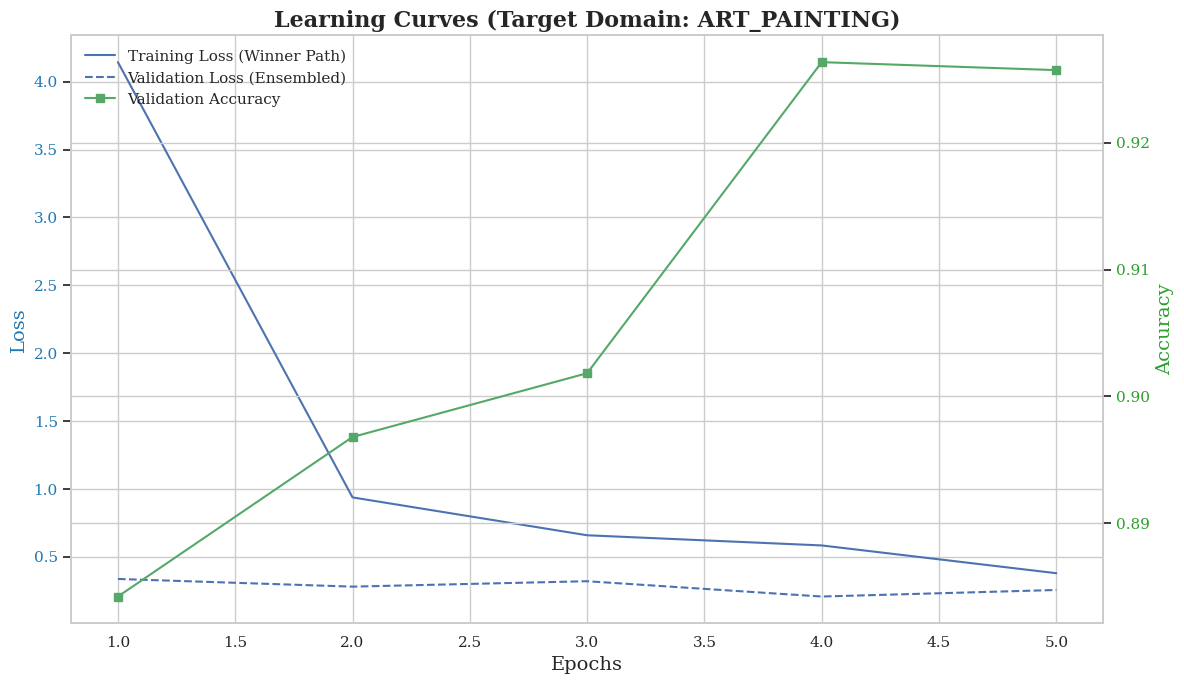

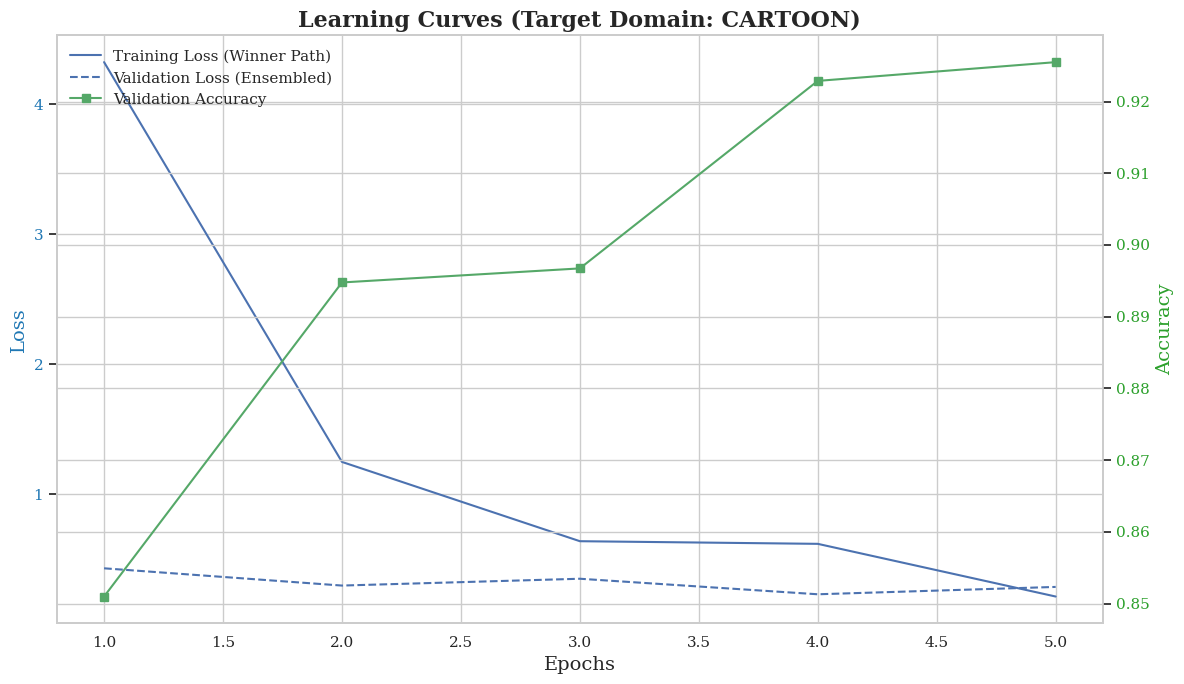

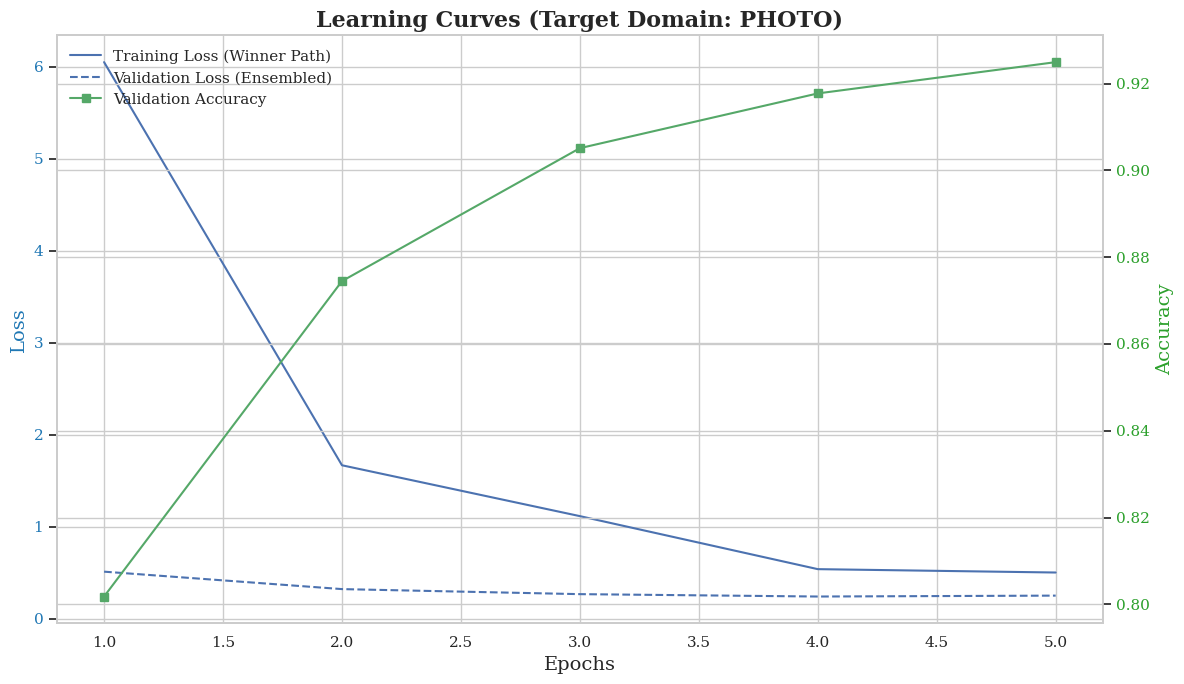

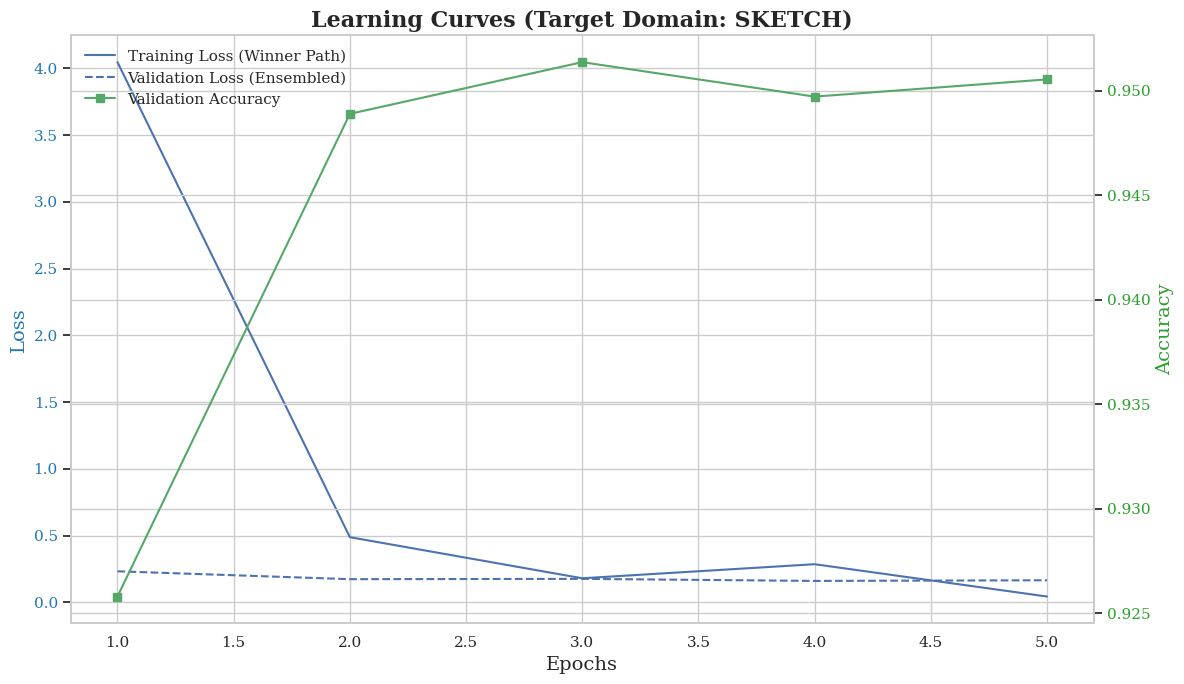

In [21]:
# =================================================================================
# SECTION 8: VISUALIZE LEARNING CURVES
# =================================================================================
print("\n" + "="*70)
print("--- Visualizing Learning Curves for Shared Head Model ---")
print("="*70)

for domain, history in lodo_histories.items():
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, ax1 = plt.subplots(figsize=(12, 7))
    
    # Plotting losses on the primary y-axis (left)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14, color='tab:blue')
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss (Winner Path)')
    ax1.plot(epochs, history['val_loss'], 'b--', label='Validation Loss (Ensembled)')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Creating a secondary y-axis for accuracy (right)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', fontsize=14, color='tab:green')
    ax2.plot(epochs, history['val_accuracy'], 'g-s', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    
    # Adding title and legends
    plt.title(f'Learning Curves (Target Domain: {domain.upper()})', fontsize=16, fontweight='bold')
    
    # A combined legend is cleaner for dual-axis plots
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')
    
    fig.tight_layout()
    plt.show()

--- Final Experiment Results ---
  target_domain  test_accuracy  best_val_accuracy  num_epochs  batch_size  learning_rate                      model_name
0  art_painting       0.801758           0.926369           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
1       cartoon       0.747440           0.925490           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
2         photo       0.959281           0.924925           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
3        sketch       0.662510           0.951360           5         128         0.0001  WinKawaks/vit-tiny-patch16-224

Average Test Accuracy Across All Domains: 0.7927


C:\Users\Fatim_Sproj\AppData\Local\Temp\ipykernel_2720\2340688840.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


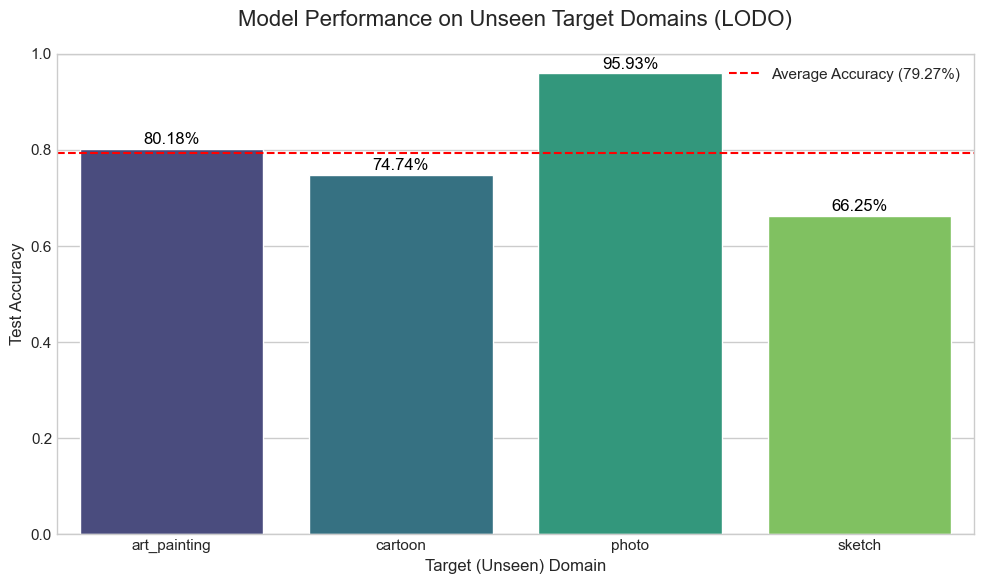


--- Dictionary for Final Plotting ---
# Copy the dictionary below and paste it into your final analysis notebook.
my_method_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.8018, 0.7474, 0.9593, 0.6625]
}

--- Experiment Complete ---


In [21]:
# =================================================================================
# SECTION 6: ANALYSIS & VISUALIZATION (with Dictionary Output)
# =================================================================================
# Now that all experiments are complete, we'll process the results
# and create visualizations to understand the performance of our method.
# ---------------------------------------------------------------------------------

# Add this magic command to ensure plots are displayed in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


# ---------------------------------------------------------------------------------
# 6.1: DISPLAY RESULTS IN A TABLE
# ---------------------------------------------------------------------------------
print("--- Final Experiment Results ---")

results_df = pd.DataFrame(experiment_results)
column_order = [
    "target_domain", "test_accuracy", "best_val_accuracy", "num_epochs",
    "batch_size", "learning_rate", "model_name"
]
existing_columns = [col for col in column_order if col in results_df.columns]
results_df = results_df[existing_columns]
average_accuracy = results_df['test_accuracy'].mean()

print(results_df.to_string())
print("\n" + "="*50)
print(f"Average Test Accuracy Across All Domains: {average_accuracy:.4f}")
print("="*50)


# ---------------------------------------------------------------------------------
# 6.2: VISUALIZE THE RESULTS
# ---------------------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(
    data=results_df, x='target_domain', y='test_accuracy', ax=ax, palette='viridis'
)

for index, row in results_df.iterrows():
    ax.text(index, row['test_accuracy'] + 0.01, f"{row['test_accuracy']:.2%}",
            color='black', ha="center", fontsize=12)
    
ax.axhline(average_accuracy, ls='--', color='red', label=f'Average Accuracy ({average_accuracy:.2%})')

ax.set_title('Model Performance on Unseen Target Domains (LODO)', fontsize=16, pad=20)
ax.set_xlabel('Target (Unseen) Domain', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_ylim(0, 1.0)
ax.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------
### NEW SECTION ###
# 6.3: GENERATE COPY-PASTE DICTIONARY FOR FINAL PLOTTING
# ---------------------------------------------------------------------------------
print("\n" + "="*70)
print("--- Dictionary for Final Plotting ---")
print("# Copy the dictionary below and paste it into your final analysis notebook.")

# Determine the variable name based on the notebook (you can adjust this)
# For the baseline notebook, you'd want 'baseline_results'.
# For the evolutionary notebook, you'd want 'evolutionary_results'.
method_name = "my_method_results" # Generic name
if "baseline" in os.getcwd(): # Simple check if 'baseline' is in the notebook path
    method_name = "baseline_results"
elif "drop-out" in os.getcwd():
    method_name = "evolutionary_results"
    
# Extract the lists from the DataFrame
domain_list = results_df['target_domain'].tolist()
accuracy_list = [round(acc, 4) for acc in results_df['test_accuracy'].tolist()]

# Print in the desired format
print(f"{method_name} = {{")
print(f"    'target_domain': {domain_list},")
print(f"    'test_accuracy': {accuracy_list}")
print(f"}}")
print("="*70)


print("\n--- Experiment Complete ---")

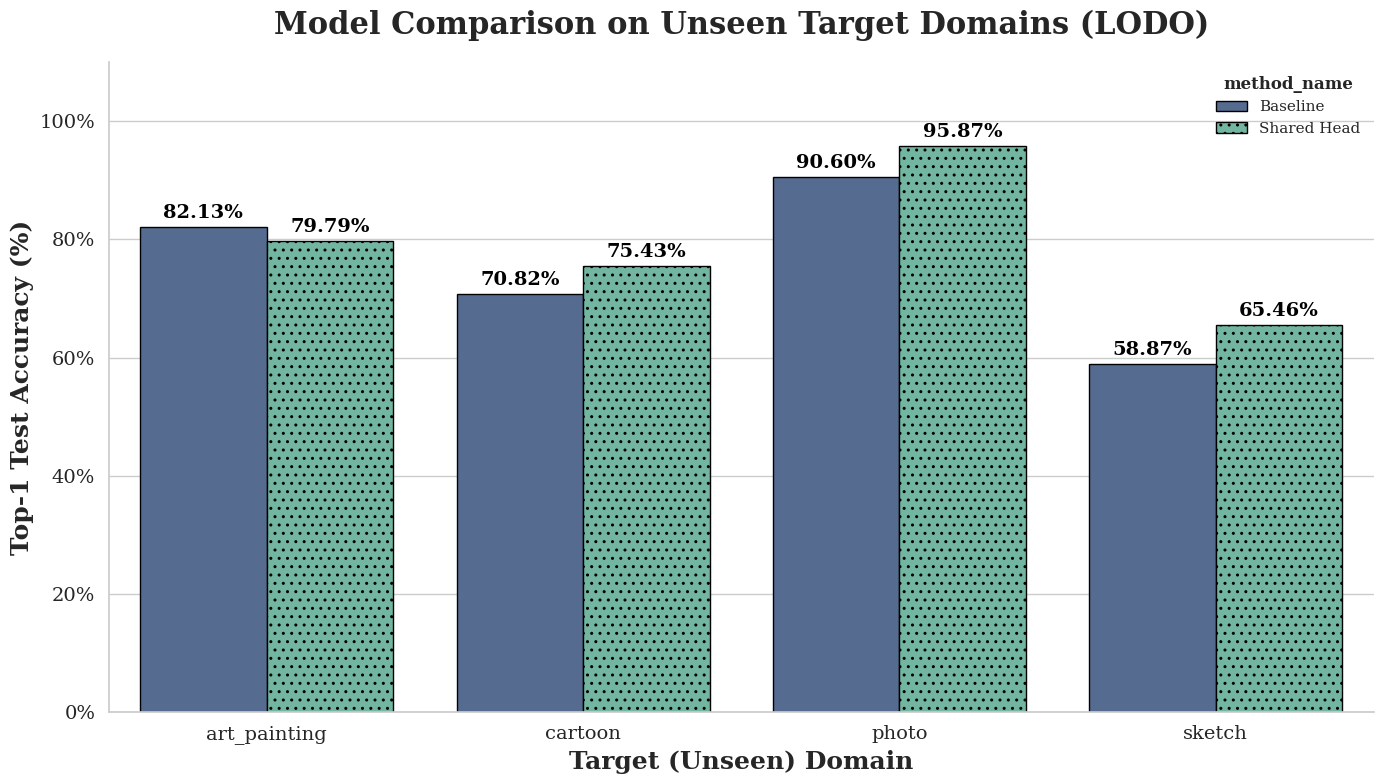


--- Average Performance Summary ---
Average Baseline Accuracy: 75.61%
Average Evolutionary Dropout Accuracy: 79.14%


In [22]:
# =================================================================================
# SECTION 7: COMPARATIVE ANALYSIS & VISUALIZATION (ACADEMIC STYLE - FINAL FIX)
# =================================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 7.1: COMBINE EXPERIMENT RESULTS ---
baseline_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.8213, 0.7082, 0.9060, 0.5887]
}
# Using the results from your successful Option 4 run
evolutionary_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.7979, 0.7543, 0.9587, 0.6546]
}
baseline_df = pd.DataFrame(baseline_results)
baseline_df['method_name'] = 'Baseline'
evolutionary_df = pd.DataFrame(evolutionary_results)
evolutionary_df['method_name'] = 'Shared Head'
combined_df = pd.concat([baseline_df, evolutionary_df])

# --- 7.2: CREATE THE GROUPED BAR CHART (ROBUST VERSION) ---

sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(14, 8))

custom_palette = {'Baseline': '#4B6A9A', 'Shared Head': '#66C2A5'}

barplot = sns.barplot(
    data=combined_df,
    x='target_domain',
    y='test_accuracy',
    hue='method_name',
    ax=ax,
    palette=custom_palette,
    edgecolor='black'
)

### THE FIX IS HERE ###
# Use the robust 'containers' method to apply patterns correctly.

# ax.containers[0] is the container for the first hue category (Baseline)
# ax.containers[1] is the container for the second hue category (Evolutionary Dropout)

# We want to add a pattern to the second container's bars.
for bar in ax.containers[1]:
    bar.set_hatch('..')

# We also need to apply the pattern to the corresponding legend handle.
# The legend handles are created in the same order.
ax.legend_.legend_handles[1].set_hatch('..')

# --- Add annotations (text on bars) ---
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            f"{p.get_height():.2%}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 10),
            textcoords='offset points',
            fontsize=14,
            fontweight='bold',
            color='black'
        )

# --- Final plot styling ---
ax.set_title('Model Comparison on Unseen Target Domains (LODO)', fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Target (Unseen) Domain', fontsize=18, fontweight='bold')
ax.set_ylabel('Top-1 Test Accuracy (%)', fontsize=18, fontweight='bold')
ax.set_ylim(0, 1.1)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

legend = ax.get_legend()
plt.setp(legend.get_title(), fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

# --- Print the final summary table ---
avg_baseline = baseline_df['test_accuracy'].mean()
avg_evolutionary = evolutionary_df['test_accuracy'].mean()
print("\n--- Average Performance Summary ---")
print(f"Average Baseline Accuracy: {avg_baseline:.2%}")
print(f"Average Evolutionary Dropout Accuracy: {avg_evolutionary:.2%}")